<a href="https://colab.research.google.com/github/ksemina61/task1semestr/blob/main/hw04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Задание 1 (из домашнего задания)**

Решите задачу распознавания лиц с помощью SVM с ядром. Попробуйте различные ядра: 'poly', 'rbf', 'sigmoid'.

Подберите гиперпараметры по кросс-валидации.

SVM с каким ядром дал лучший результат?

In [ ]:
# Сначала рассмотрю линейное ядро из семинара
# Самое первое ядро - Линейное ядро (Linear kernel) - гиперплоскость для разделения данных. Оно часто используется в задачах с линейно разделимыми данными.

Линейное ядро (Linear kernel) — это самое простое ядро, которое строит гиперплоскость для разделения данных. Оно часто используется в задачах с линейно разделимыми данными. В математическом смысле линейное ядро вычисляет скалярное произведение между векторами признаков объектов.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Нарисуем несколько лиц из датасета

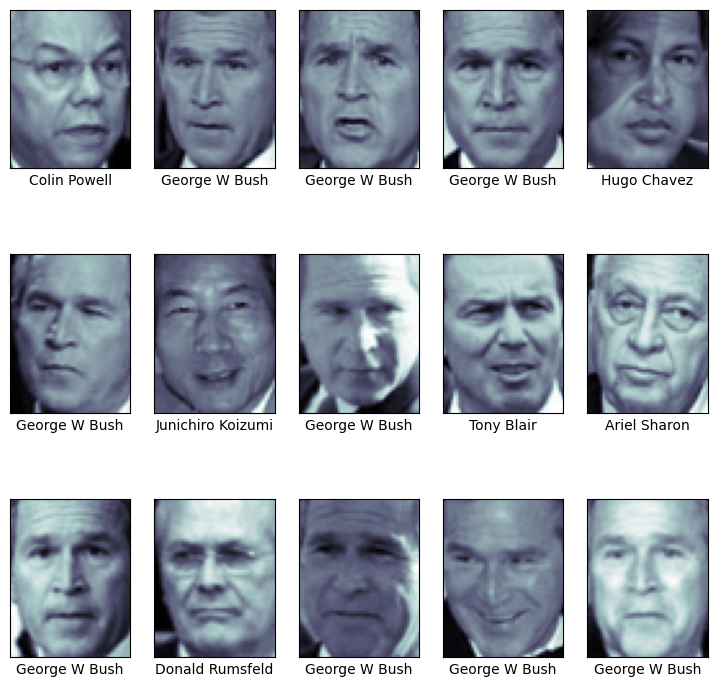

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(9,9)) # картинка - матрица, таблица из чисел, пиксель и интенсивность цвета
for i, axi in enumerate(ax.flat): # картинку можно превратить в набор чисел, но получается много признаков, метод основных компонентов
    axi.imshow(faces.images[i], cmap='bone') # Метод основных компонентов - метод кластеризации, все наши признаки - матрица, преобразовать матрицу, чтобы уменьшить признаки, взять два взаимосвязных признака и на их основе выделить третий.
    axi.set(xticks=[], yticks=[],  # таким образом мы уменьшаем признаки от 3000 до 150
            xlabel=faces.target_names[faces.target[i]])

In [ ]:
faces.images.shape
# Используется для получения информации о форме (размерах) массива изображений лиц.
# Другими словами, он позволяет узнать количество изображений, их ширину, высоту и количество.

(1348, 62, 47)

Каждое изображение имеет размер [62×47] - это примерно 3000 пикселей. Мы можем использовать пиксели как признаки, но давайте понизим размерность пространства признаков.

Извлечем 150 самых информативных признаков из данных фотографий методом RandomizedPCA (помним, что это метод уменьшения размерности).

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

Попробуем решить задачу алгоритмом SVM.

In [ ]:
svc = SVC(kernel='linear')
model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 13.4 s, sys: 10.3 s, total: 23.7 s
Wall time: 13.9 s
{'svc__C': 1}


In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

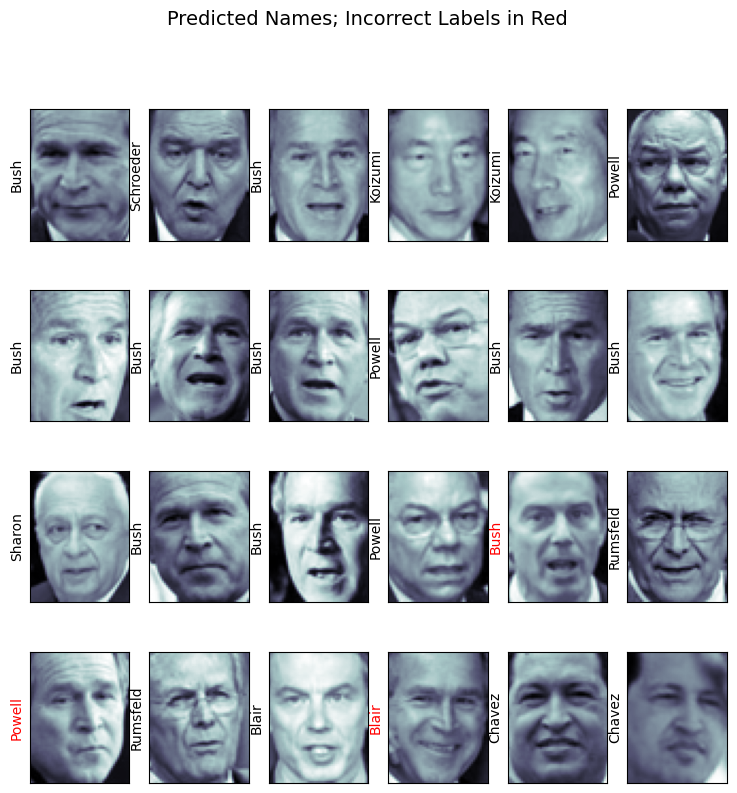

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Выведем на экран метрики классификации.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.67      0.65        15
     Colin Powell       0.78      0.85      0.82        68
  Donald Rumsfeld       0.71      0.71      0.71        31
    George W Bush       0.84      0.79      0.81       126
Gerhard Schroeder       0.68      0.74      0.71        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.73      0.76      0.74        42

         accuracy                           0.78       337
        macro avg       0.77      0.78      0.77       337
     weighted avg       0.79      0.78      0.78       337



Нарисуем матрицу ошибок классификатора.

0.7833827893175074

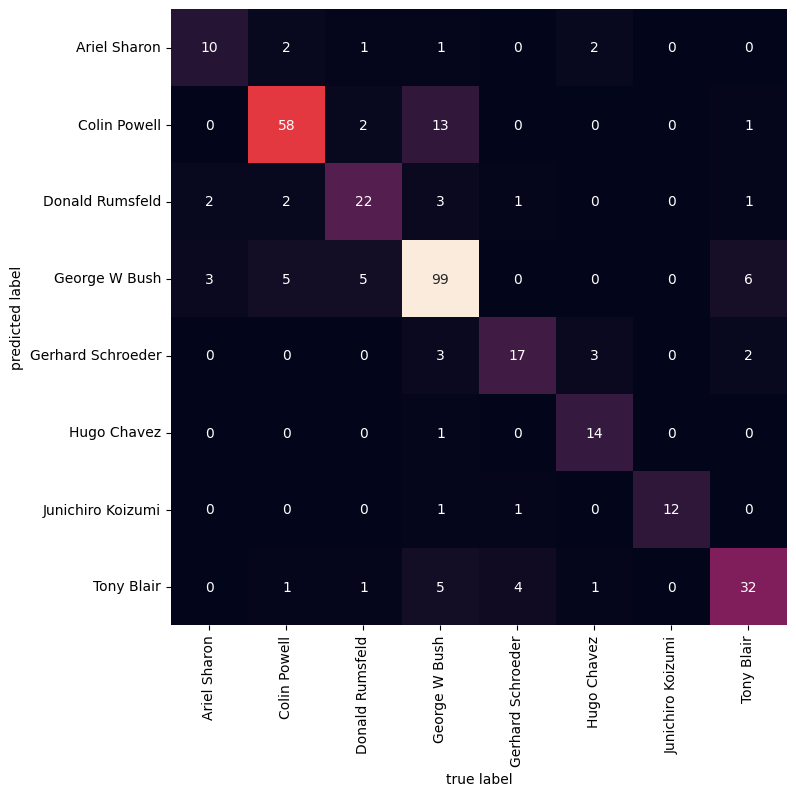

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

0.7833827893175074

Затем рассмотрю ядро - Radial Basis Function (RBF) — это наиболее распространенное ядро, которое может разделять данные, не являющиеся линейно разделимыми.

Здесь используется гиперпараметр gamma.
Гиперпараметр gamma в ядре rbf (радиально-базисная функция) в SVM (метод опорных векторов) отвечает за ширину радиальной функции.
Изменение этого параметра влияет на гибкость модели: маленькое значение gamma приводит к более плавным границам решения, что может привести к недообучению, а большее значение gamma создает более сложные границы решения, что может привести к переобучению модели.

Заново нарисуем лица из датасета.

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


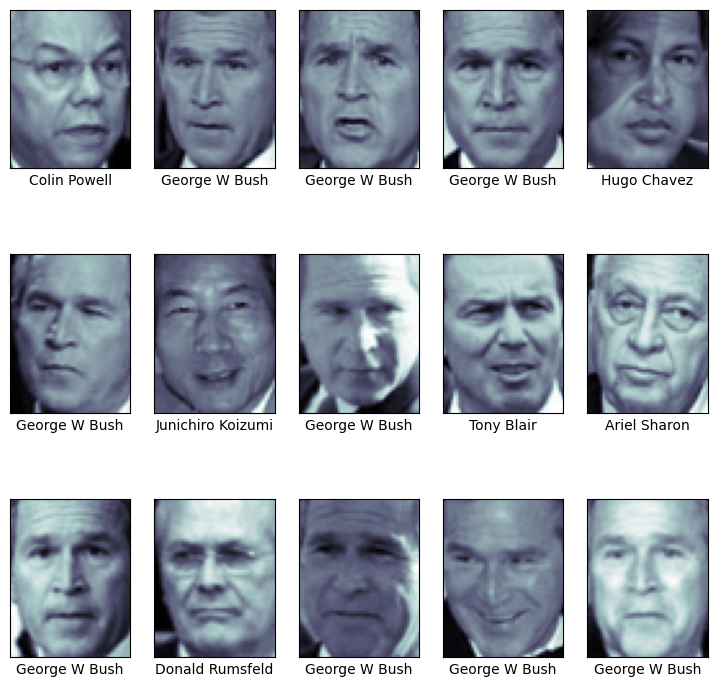

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(9,9)) # картинка - матрица, таблица из чисел, пиксель и интенсивность цвета
for i, axi in enumerate(ax.flat): # картинку можно превратить в набор чисел, но получается много признаков, метод основных компонентов
  axi.imshow(faces.images[i], cmap='bone') # Метод основных компонентов - метод кластеризации, все наши признаки - матрица, преобразовать матрицу, чтобы уменьшить признаки, взять два взаимосвязных признака и на их основе выделить третий.
  axi.set(xticks=[], yticks=[],  # таким образом мы уменьшаем признаки от 3000 до 150
          xlabel=faces.target_names[faces.target[i]])

In [ ]:
faces.images.shape

(1348, 62, 47)

Понизим размерность пространства признаков. Извлечем 150 самых информативных признаков из данных фотографий методом RandomizedPCA (это метод уменьшения размерности).

In [ ]:
# Понизим размерность
from sklearn.svm import SVC
from sklearn.decomposition import PCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

rbf_svc = SVC(kernel='rbf')
model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)


In [ ]:
# Подбор параметров C и gamma для ядра rbf
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__kernel': ['rbf'], 'svc__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
best_params = grid.best_params_
print('Лучшие параметры:', best_params)

CPU times: user 2min 21s, sys: 1min 35s, total: 3min 57s
Wall time: 2min 25s
Лучшие параметры: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


GridSearch - нужен для поиска наилучших параметров модели с помощью перекрестной проверки (кросс-валидации).

(param_grid): устанавливается сетка параметров, которую GridSearchCV  будет исследовать при подборе лучших параметров модели.

%time grid.fit(Xtrain, ytrain): выполняет поиск лучших параметров модели с использованием метода fit объекта GridSearchCV.

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        15
     Colin Powell       0.00      0.00      0.00        68
  Donald Rumsfeld       0.00      0.00      0.00        31
    George W Bush       0.37      1.00      0.54       126
Gerhard Schroeder       0.00      0.00      0.00        23
      Hugo Chavez       0.00      0.00      0.00        20
Junichiro Koizumi       0.00      0.00      0.00        12
       Tony Blair       0.00      0.00      0.00        42

         accuracy                           0.37       337
        macro avg       0.05      0.12      0.07       337
     weighted avg       0.14      0.37      0.20       337



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Выведем на экран метрики классификации.

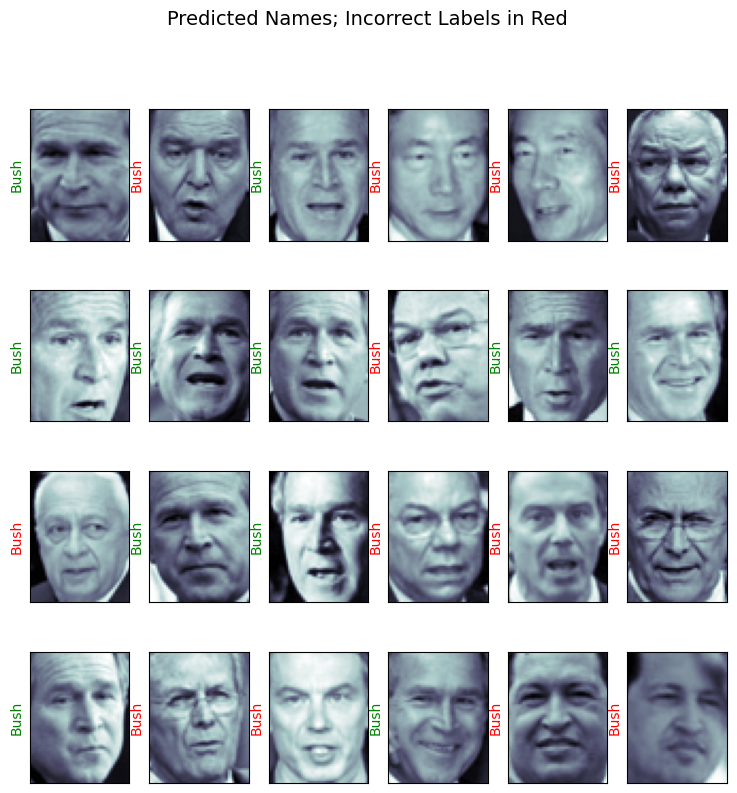

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='green' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [ ]:
# Рассчет точности модели на тестовом наборе
y_pred = grid.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('Точность на тестовом наборе: {:.2f}%'.format(accuracy * 100))

Точность на тестовом наборе: 37.39%


Нарисуем матрицу ошибок классификатора для rbf ядра

0.37388724035608306

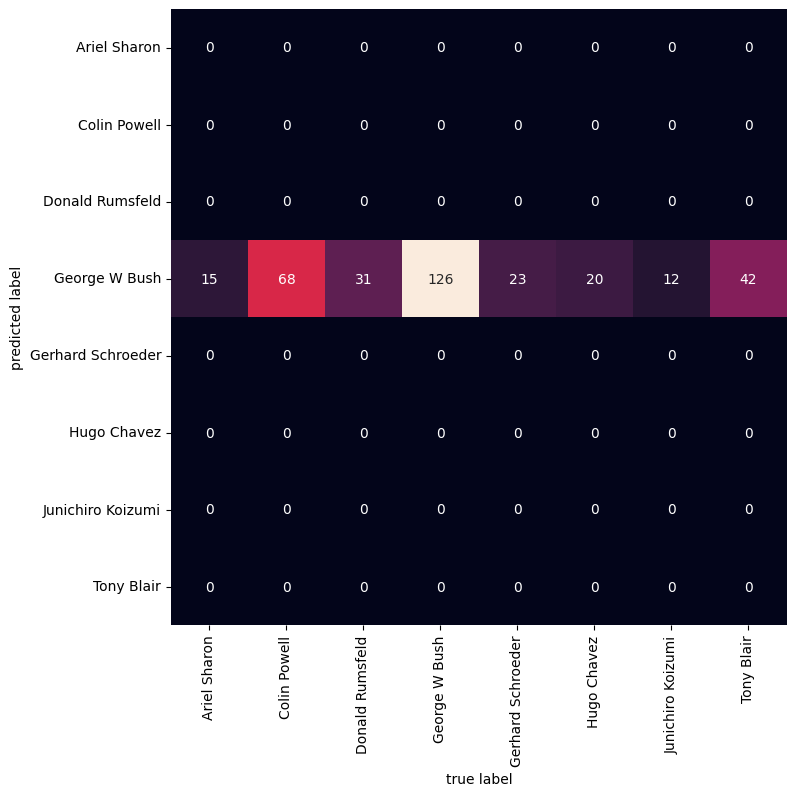

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(yfit, ytest)
# Преобразуем точность в процентное значение с двумя знаками после запятой
accuracy_percent = "{:.2f}%".format(accuracy * 100)
print(accuracy_percent)

37.39%


In [ ]:
# Убрала параметр gamma, получились другие результаты

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

rbf_svc = SVC(kernel='rbf')
model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)
# Подберу параметры
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__kernel': ['rbf']}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 16.2 s, sys: 10.8 s, total: 27.1 s
Wall time: 18.2 s
{'svc__C': 5, 'svc__kernel': 'rbf'}


In [ ]:
# Рассчет точности модели на тестовом наборе
y_pred = grid.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('Точность на тестовом наборе: {:.2f}%'.format(accuracy * 100))

Точность на тестовом наборе: 83.38%


Пока мы сравнили два ядра: linear и rbf.
Если применить параметр gamma в rbf точность и качество модели очень сильно ухудшается по сравнению с линейной. Однако, если не указывать показатель gamma, то качество, наоборот, улучшается на rbf в самом конце выдало (83.38%), на linear точность = 78.33. Кроме того, f1-score показатели лучше на rbf, чем на linear.

Вообщем, если учитывать gamma, то качество хуже, если их не учитывать, то качество почему-то лучше.
Продолжим выполнение задания, сейчас посмотрю на ядро 'poly'.

Ядро с полиномиальной функцией (Polynomial kernel) — это ядро, которое вводит полиномиальную функцию в пространство признаков для разделения данных. Это может быть полезно для данных, которые не могут быть разделены гиперплоскостью.
Это ядро ​​используется, когда данные не могут быть разделены линейно.

В ядре с полиномильной функцией часто рассматривается параметр degree. Параметр degree определяет, насколько сложную функцию полинома следует использовать для создания нелинейного решения.

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [ ]:
svc = SVC(kernel='poly')
model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [ ]:
# Подбор параметров C и degree для ядра poly
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__kernel': ['poly'], 'svc__degree': [1, 2, 3, 4, 5]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
best_params = grid.best_params_
print('Лучшие параметры:', best_params)

CPU times: user 1min 10s, sys: 49.7 s, total: 1min 59s
Wall time: 1min 12s
Лучшие параметры: {'svc__C': 5, 'svc__degree': 1, 'svc__kernel': 'poly'}


In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.73      0.73        15
     Colin Powell       0.76      0.82      0.79        68
  Donald Rumsfeld       0.69      0.71      0.70        31
    George W Bush       0.84      0.82      0.83       126
Gerhard Schroeder       0.79      0.83      0.81        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.80      0.79      0.80        42

         accuracy                           0.80       337
        macro avg       0.80      0.80      0.80       337
     weighted avg       0.80      0.80      0.80       337



In [ ]:
svc = SVC(kernel='poly', degree = 1, C = 5.0) # На всякий случай перепроверила, ввела вручную лучшие параметры, который выбрал гридсерч
model = make_pipeline(pca, svc)

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.73      0.73        15
     Colin Powell       0.76      0.82      0.79        68
  Donald Rumsfeld       0.69      0.71      0.70        31
    George W Bush       0.84      0.82      0.83       126
Gerhard Schroeder       0.79      0.83      0.81        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.80      0.79      0.80        42

         accuracy                           0.80       337
        macro avg       0.80      0.80      0.80       337
     weighted avg       0.80      0.80      0.80       337



In [ ]:
# Рассчет точности модели на тестовом наборе
y_pred = grid.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('Точность на тестовом наборе: {:.2f}%'.format(accuracy * 100))

Точность на тестовом наборе: 80.12%


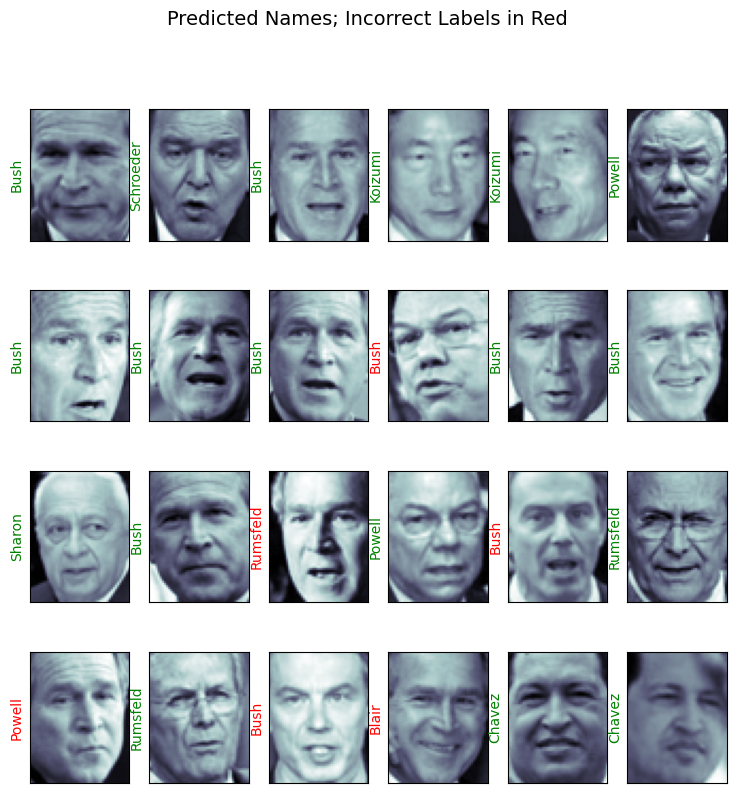

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='green' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

0.8011869436201781

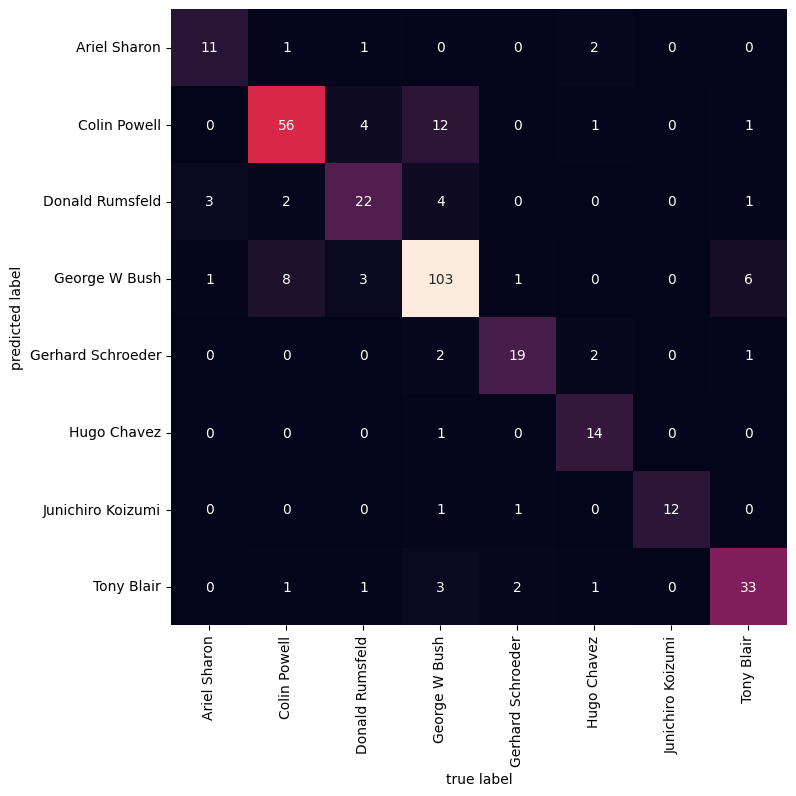

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

Итак с полиномиальной функцией показатели пока лучше, чем на rbf и на линейной. Точность здесь достигает около 80%, а внутри f1-score, precision and recall не сильно отклоняются друг от друга, как например, в rbf.

Рассмотрим последнее ядро - 'sigmoid'.

Ядро с сигмоидной функцией (Sigmoid kernel) — это ядро, которое используется для моделирования нейронных сетей. Оно может работать с нелинейными данными, но не так эффективно, как RBF-ядро.
Здесь важным параметром может быть: coef0

В чем отличия между C и coef0 ?

Параметры C и coef0 влияют на модель SVM по-разному: C регулирует сложность модели и штраф за ошибки классификации, а coef0 контролирует форму сигмоидной функции и ее поведение.

1. Параметр coef0:
   - Параметр coef0 в ядре сигмоидной функции контролирует сдвиг (bias) в сигмоидной функции, который влияет на форму кривой.
   - Значение coef0 позволяет настроить форму сигмоидной функции и ее поведение в зависимости от данных.
   - Например, если coef0=0, то сигмоидная функция будет проходить через ноль, а если coef0 отлично от нуля, то сигмоидная функция будет сдвинута.



In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [ ]:
svc = SVC(kernel='sigmoid')
model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [ ]:
# Подбор параметров C и coef0 для ядра sigmoid
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__kernel': ['sigmoid'], 'svc__coef0': [-1, -0.5, 0.5, 1]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
best_params = grid.best_params_
print('Лучшие параметры:', best_params)

CPU times: user 55.4 s, sys: 40.1 s, total: 1min 35s
Wall time: 56.7 s
Лучшие параметры: {'svc__C': 5, 'svc__coef0': -1, 'svc__kernel': 'sigmoid'}


In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.87      0.79        15
     Colin Powell       0.88      0.87      0.87        68
  Donald Rumsfeld       0.77      0.77      0.77        31
    George W Bush       0.88      0.90      0.89       126
Gerhard Schroeder       0.86      0.78      0.82        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.88      0.90      0.89        42

         accuracy                           0.86       337
        macro avg       0.86      0.85      0.85       337
     weighted avg       0.87      0.86      0.86       337



In [ ]:
# Рассчет точности модели на тестовом наборе
y_pred = grid.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('Точность на тестовом наборе: {:.2f}%'.format(accuracy * 100))

Точность на тестовом наборе: 86.35%


In [ ]:
# svc = SVC(kernel='poly',C = 5.0, coef0 = -1) # На всякий случай перепроверила, ввела вручную лучшие параметры, который выбрал гридсерч
# model = make_pipeline(pca, svc)

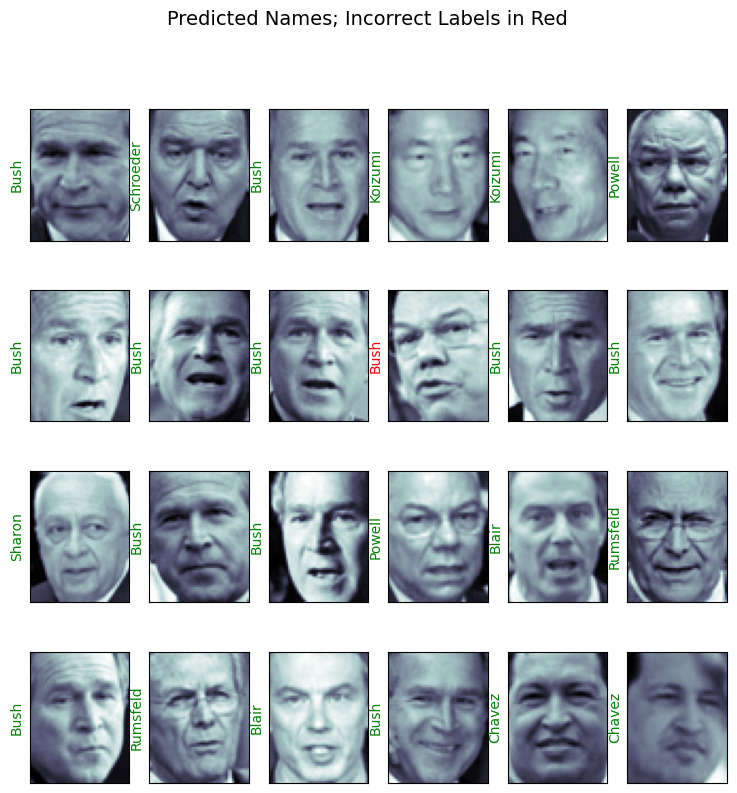

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='green' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

0.8635014836795252

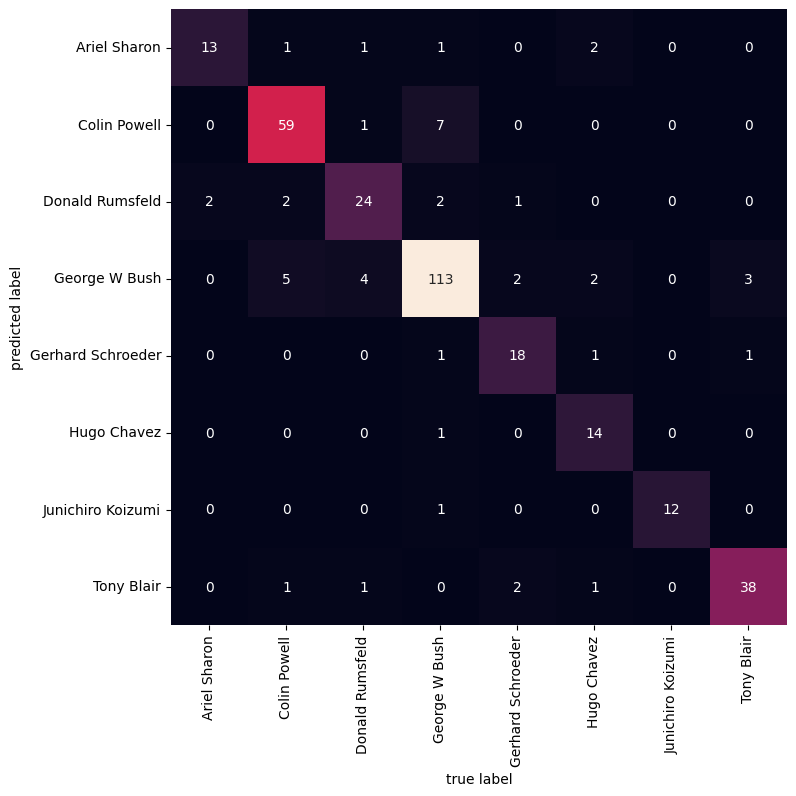

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

Вывод: для параметра C = [1,5,10,50], лучшие показатели и лучшее качество было на ядре sigmoid' (около 86.32%), затем идет ядро 'poly' (80.12%), затем линейной ядро (79%) и в самом конце rbf (37%).

Возможно, если бы я поэкспериментировала с показателями C, то качество на rbf улучшилось бы, но я рассматривала на этих данных.

### **Задание 2 (из домашнего задания)**

Решите задачу распознавания лиц с помощью логистической регрессии (она также поддерживает опцию class_weight='balanced'):

1) Объявите модель, состоящую из pipeline(pca,logistic regression)

2) Подберите по сетке параметр C логистической регрессии (с помощью GridSearch)

3) Обучите модель на тренировочных данных и выведите наилучшие параметры модели

Какое качество показала эта модель?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Нарисуем несколько лиц из датасета

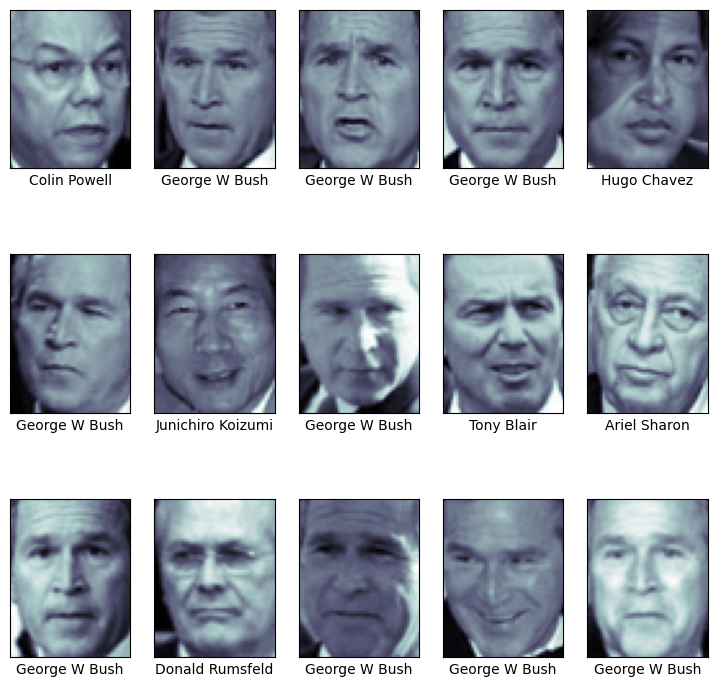

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Для начала нужно посмотреть, что со значениями. Пустых значений вроде бы нет. Типы данных - float.

In [ ]:
import pandas as pd
# Преобразование изображений в одномерный массив для создания DataFrame
data = faces.images.reshape((faces.images.shape[0], -1))
df = pd.DataFrame(data)
print("Пустые значения:")
print(df.isnull().sum())
print("\nТипы данных:")
print(df.dtypes)

Пустые значения:
0       0
1       0
2       0
3       0
4       0
       ..
2909    0
2910    0
2911    0
2912    0
2913    0
Length: 2914, dtype: int64

Типы данных:
0       float32
1       float32
2       float32
3       float32
4       float32
         ...   
2909    float32
2910    float32
2911    float32
2912    float32
2913    float32
Length: 2914, dtype: object


In [ ]:
X = faces.data
y = faces.target

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

In [ ]:
svc = SVC(kernel='linear')
model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

1) Объявила модель, состоящую из pipeline(pca,logistic regression)

In [ ]:
# Стандартизация
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('model', LogisticRegression(class_weight='balanced'))])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}
grid = GridSearchCV(pipe, param_grid)
%time grid.fit(Xtrain, ytrain)
best_params = grid.best_params_
print('Лучшие параметры:', best_params)
# Лучшие параметры: {'model__C': 1}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CPU times: user 1min 33s, sys: 26.7 s, total: 2min
Wall time: 1min 9s
Лучшие параметры: {'model__C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
logreg_balanced = LogisticRegression(class_weight='balanced') #  балансировка классов с использованием параметра class_weight='balanced
logreg_balanced.fit(Xtrain, ytrain)
# Предсказания на обучающем и тестовом наборах
y_pred_train_balanced = logreg_balanced.predict(Xtrain)
y_pred_test_balanced = logreg_balanced.predict(Xtest)

print("Classification Report for Training Set (Balanced Model):")
print(classification_report(ytrain, y_pred_train_balanced))

print("\nClassification Report for Test Set (Balanced Model):")
print(classification_report(ytest, y_pred_test_balanced))

# Оценка точности модели
accuracy_balanced = accuracy_score(ytest, y_pred_test_balanced)
print("Accuracy for Balanced Model: {:.2f}%".format(accuracy_balanced * 100))


Classification Report for Training Set (Balanced Model):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.97      0.98      0.98       168
           2       0.93      1.00      0.96        90
           3       0.99      0.96      0.97       404
           4       0.99      1.00      0.99        86
           5       1.00      1.00      1.00        51
           6       0.98      1.00      0.99        48
           7       0.97      1.00      0.99       102

    accuracy                           0.98      1011
   macro avg       0.98      0.99      0.98      1011
weighted avg       0.98      0.98      0.98      1011


Classification Report for Test Set (Balanced Model):
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.91      0.87      0.89        68
           2       0.71      0.77      0.74        31
           3       0.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Оценка точности модели
accuracy_balanced = accuracy_score(ytest, y_pred_test_balanced)
print("Accuracy for Balanced Model: {:.2f}%".format(accuracy_balanced * 100))

Accuracy for Balanced Model: 83.68%


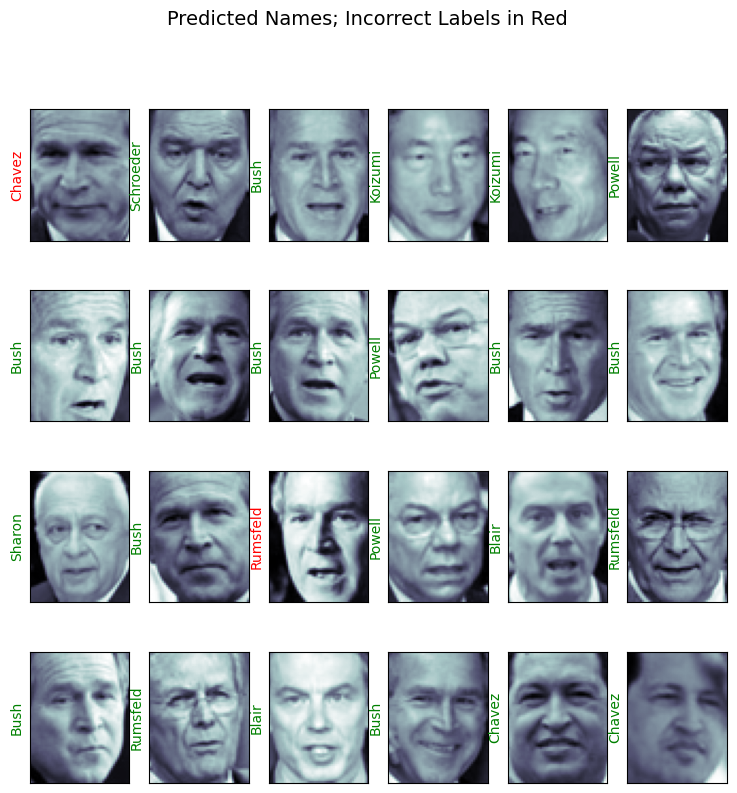

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='green' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

0.8456973293768546

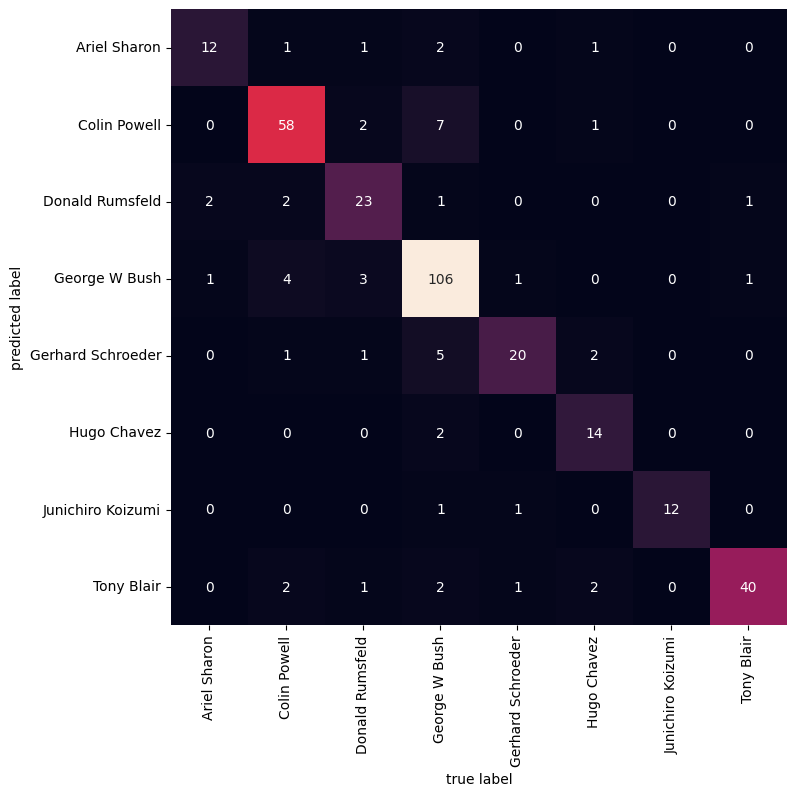

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

В итоге точность была определена примерно 83.68%, что говорит о том, что модель неплохо определяет с помощью class_weight точность. Однако модель скорее всего немного переобучилась, так как f1-score, recall, precision имеют отклонения с train и test. На train показатели больше, чем на test.

### **Задание 3 (из домашнего задания)**

Разбалловка:

- 5 баллов: обучили один алгоритм и погридсерчили
- 10 баллов: попробовали обучить два и более алгоритмов, погридсерчили

Поработайте с датасетом winequalityN (целевая переменная - quality). Поэкспериментируйте с алгоритмами классификации, попробуйте подобрать гиперпараметры для них.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

In [ ]:
import pandas as pd

df = pd.read_csv('winequalityN.csv')
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [ ]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [ ]:
df.dropna(inplace=True) # удалю пропущенные значения

In [ ]:
df.head().copy()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   object 
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 706.9+ KB


<Axes: xlabel='type', ylabel='count'>

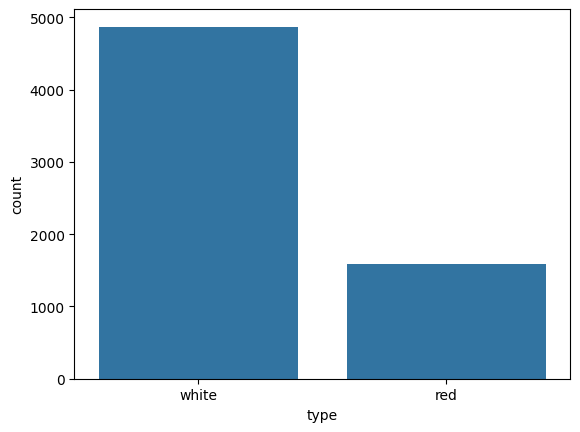

In [ ]:
import seaborn as sns
sns.countplot(x='type', data=df)

In [ ]:
df['type'] = df['type'].apply(lambda x: 1 if x == 'white' else 0)

In [ ]:
df.head().copy() # поменяла объект, теперь все числа

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1            7.0              0.27         0.36            20.7   
1     1            6.3              0.30         0.34             1.6   
2     1            8.1              0.28         0.40             6.9   
3     1            7.2              0.23         0.32             8.5   
4     1            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
pd.get_dummies(df["type"])
sex = pd.get_dummies(df["type"])

In [ ]:
df.head().copy()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1            7.0              0.27         0.36            20.7   
1     1            6.3              0.30         0.34             1.6   
2     1            8.1              0.28         0.40             6.9   
3     1            7.2              0.23         0.32             8.5   
4     1            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [ ]:
# Посмотрим на матрицу

<Axes: >

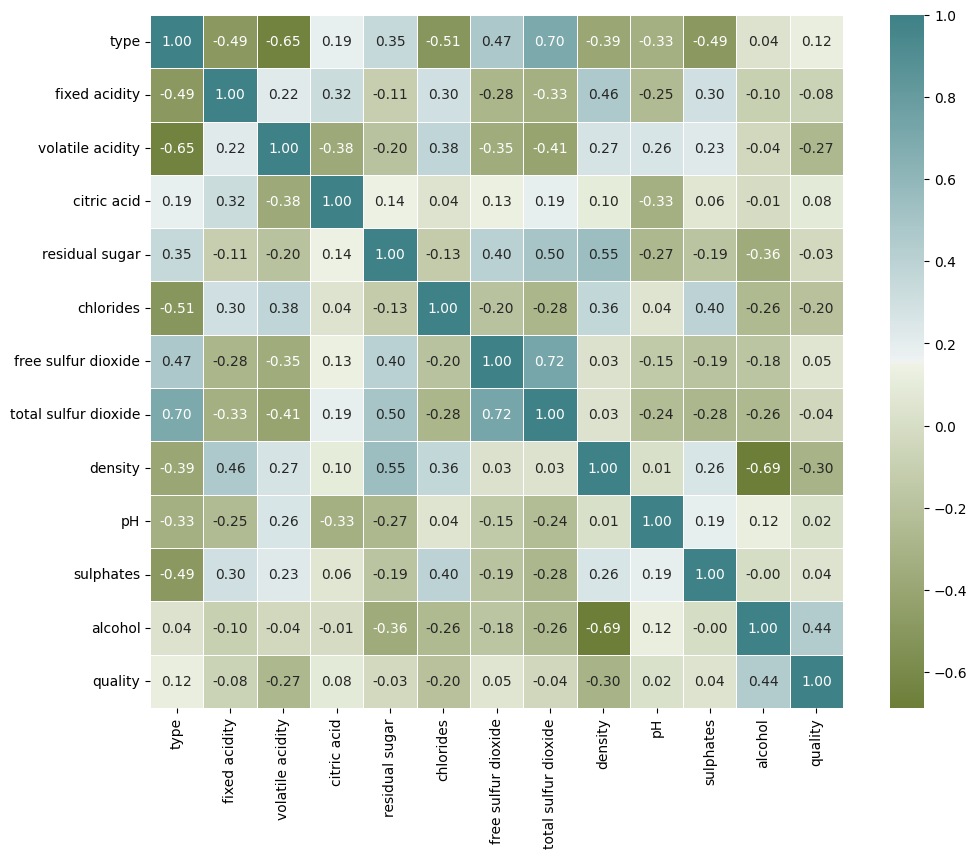

In [ ]:
import seaborn as sns
import numpy as np
from matplotlib import pylab as plt
plt.figure(figsize=(12, 9))
corr = df.corr()
sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

In [ ]:
df.drop(['free sulfur dioxide'], axis=1, inplace=True)

In [ ]:
# дальше будет выдавать предупреждение, что мало объектов.
df['quality'] = df['quality'].apply(lambda x: 8 if x == 9 else x)

In [ ]:
df = df.fillna(df.mean())

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
X = df.drop('quality', axis=1)
y = df['quality']
# Разделим данные на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y)

# **KNN Classifier**

In [ ]:
def plotting(grid, params):
    scores_mean = grid.cv_results_['mean_test_score']
    scores_sd = grid.cv_results_['std_test_score']
    plt.plot(params, scores_mean, label='scores_mean')
    plt.fill_between(params, (scores_mean-scores_sd), (scores_mean+scores_sd), color='g', alpha=.1, label='std')
    plt.xlabel('params')
    plt.ylabel('cv_score')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def model_train(model, param_grid, hyperparams):
    grid = GridSearchCV(model, param_grid, cv=3)

    grid.fit(X_train, y_train)
    plotting(grid, hyperparams)
    print(f'Best params: {grid.best_params_}')

    best = grid.best_estimator_
    y_pred_train = best.predict(X_train)
    y_pred_test = best.predict(X_test)
    print(classification_report(y_train, y_pred_train), classification_report(y_test, y_pred_test))

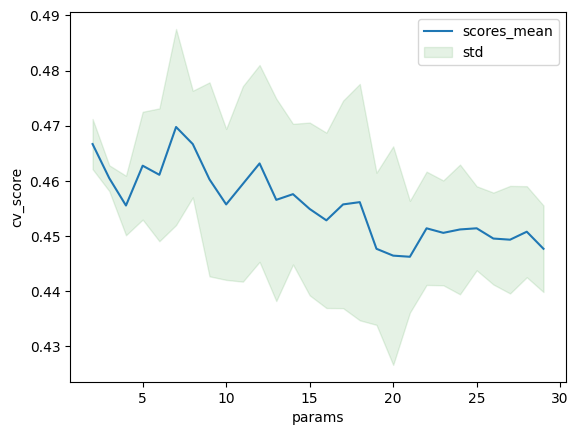

Best params: {'n_neighbors': 7}
              precision    recall  f1-score   support

           3       0.57      0.16      0.25        25
           4       0.41      0.11      0.18       159
           5       0.63      0.69      0.66      1580
           6       0.61      0.72      0.66      2113
           7       0.62      0.44      0.52       823
           8       0.57      0.11      0.18       147

    accuracy                           0.62      4847
   macro avg       0.57      0.37      0.41      4847
weighted avg       0.61      0.62      0.60      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.17      0.05      0.08        55
           5       0.54      0.57      0.56       548
           6       0.51      0.58      0.54       707
           7       0.36      0.30      0.33       251
           8       0.43      0.06      0.11        50

    accuracy                           0.50  

In [ ]:
model = KNeighborsClassifier()
hyperparams = list(range(2, 30))
param_grid = {'n_neighbors': hyperparams}

model_train(model, param_grid, hyperparams)

Выдал, что лучшие гиперпараметры: {'knn__n_neighbors': 7}


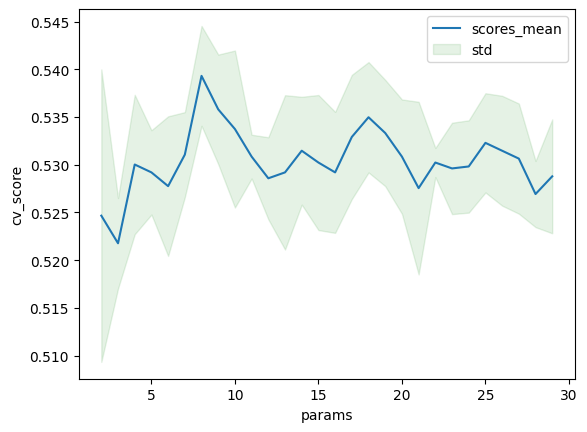

Best params: {'kneighborsclassifier__n_neighbors': 8}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        25
           4       0.55      0.14      0.23       159
           5       0.67      0.73      0.70      1580
           6       0.65      0.72      0.68      2113
           7       0.62      0.51      0.56       823
           8       0.50      0.12      0.20       147

    accuracy                           0.65      4847
   macro avg       0.50      0.37      0.39      4847
weighted avg       0.64      0.65      0.63      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.40      0.11      0.17        55
           5       0.61      0.65      0.63       548
           6       0.55      0.62      0.58       707
           7       0.44      0.37      0.40       251
           8       0.15      0.04      0.06        50

    accuracy           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.pipeline import make_pipeline
scale = StandardScaler()
knn = KNeighborsClassifier()
model = make_pipeline(scale, knn)
hyperparams = list(range(2, 30))
param_grid = {'kneighborsclassifier__n_neighbors': hyperparams}
model_train(model, param_grid, hyperparams)

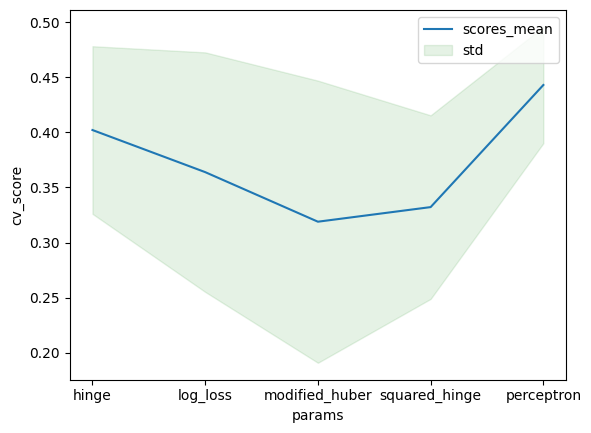

Best params: {'loss': 'perceptron'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00       159
           5       0.53      0.72      0.61      1580
           6       0.55      0.12      0.19      2113
           7       0.29      0.78      0.42       823
           8       0.11      0.04      0.06       147

    accuracy                           0.42      4847
   macro avg       0.25      0.28      0.21      4847
weighted avg       0.46      0.42      0.35      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        55
           5       0.56      0.70      0.62       548
           6       0.53      0.12      0.20       707
           7       0.27      0.80      0.40       251
           8       0.00      0.00      0.00        50

    accuracy                           0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
model = SGDClassifier()
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'loss': hyperparams}
model_train(model, param_grid, hyperparams)

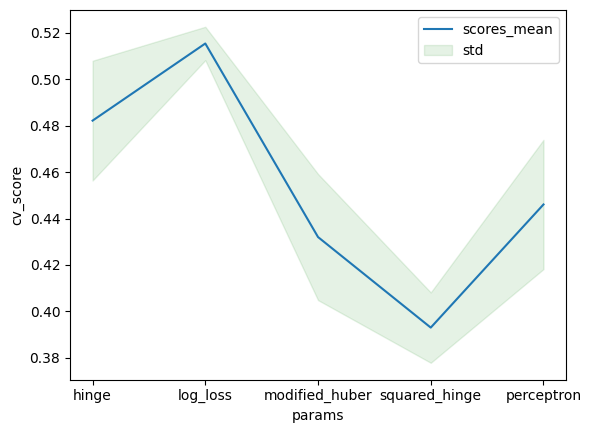

Best params: {'sgdclassifier__loss': 'log_loss'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        25
           4       0.75      0.02      0.04       159
           5       0.60      0.48      0.53      1580
           6       0.50      0.73      0.60      2113
           7       0.47      0.28      0.36       823
           8       0.00      0.00      0.00       147

    accuracy                           0.52      4847
   macro avg       0.39      0.25      0.25      4847
weighted avg       0.52      0.52      0.49      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.05      0.10        55
           5       0.66      0.47      0.55       548
           6       0.50      0.74      0.60       707
           7       0.38      0.26      0.31       251
           8       0.00      0.00      0.00        50

    accuracy                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
scale = StandardScaler()
sgd = SGDClassifier()
model = make_pipeline(scale, sgd)
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'sgdclassifier__loss': hyperparams}
model_train(model, param_grid, hyperparams)

# **Посмотрим, можно ли это решить с помощью деревьев.**

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree # визуализация деревьев

In [ ]:
df.head().copy()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1            7.0              0.27         0.36            20.7   
1     1            6.3              0.30         0.34             1.6   
2     1            8.1              0.28         0.40             6.9   
3     1            7.2              0.23         0.32             8.5   
4     1            7.2              0.23         0.32             8.5   

   chlorides  total sulfur dioxide  density    pH  sulphates  alcohol  quality  
0      0.045                 170.0   1.0010  3.00       0.45      8.8        6  
1      0.049                 132.0   0.9940  3.30       0.49      9.5        6  
2      0.050                  97.0   0.9951  3.26       0.44     10.1        6  
3      0.058                 186.0   0.9956  3.19       0.40      9.9        6  
4      0.058                 186.0   0.9956  3.19       0.40      9.9        6

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline
X = df.drop('quality', axis=1)
y = df['quality']
# Разделим данные на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y)

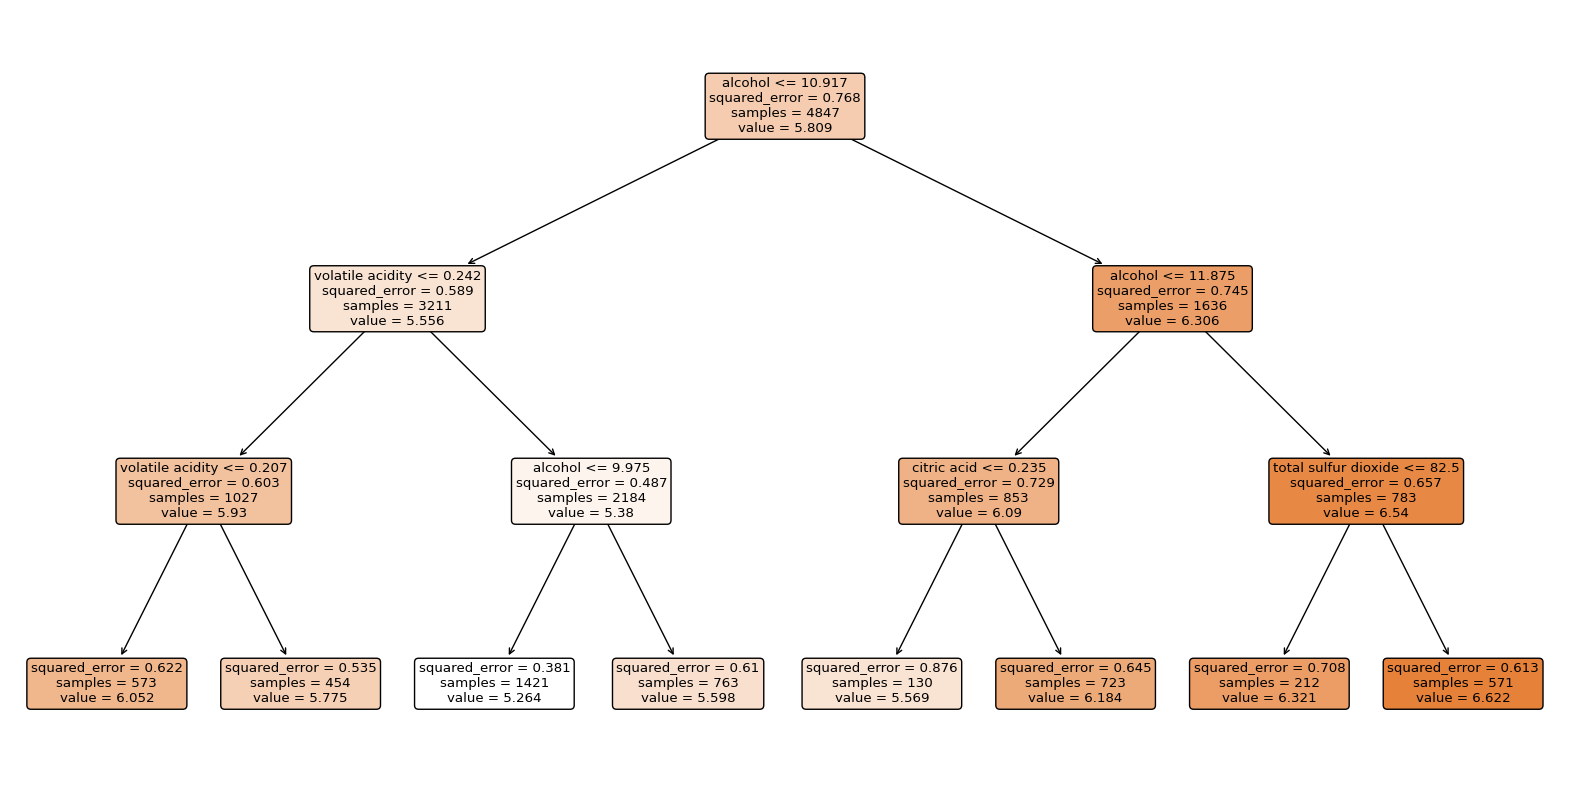

In [ ]:
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
plt.figure(figsize=(20, 10))  # установка размера фигуры 20x10
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [ ]:
mean_squared_error(y_test, dt.predict(X_test))

0.5671361665522637

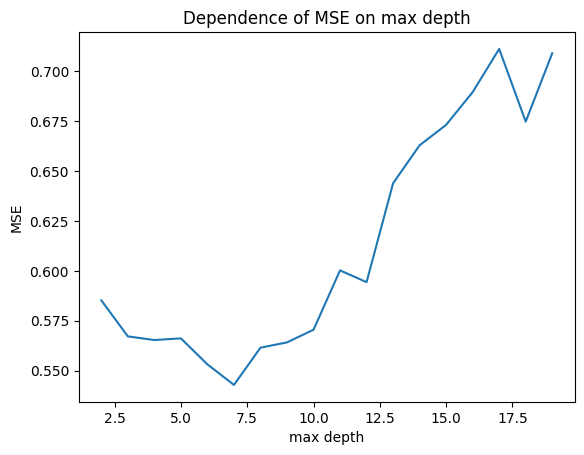

In [ ]:
max_depth_array = range(2, 20) # влияние ограничений максимальной глубины
mse_array = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))
plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE")
plt.show()

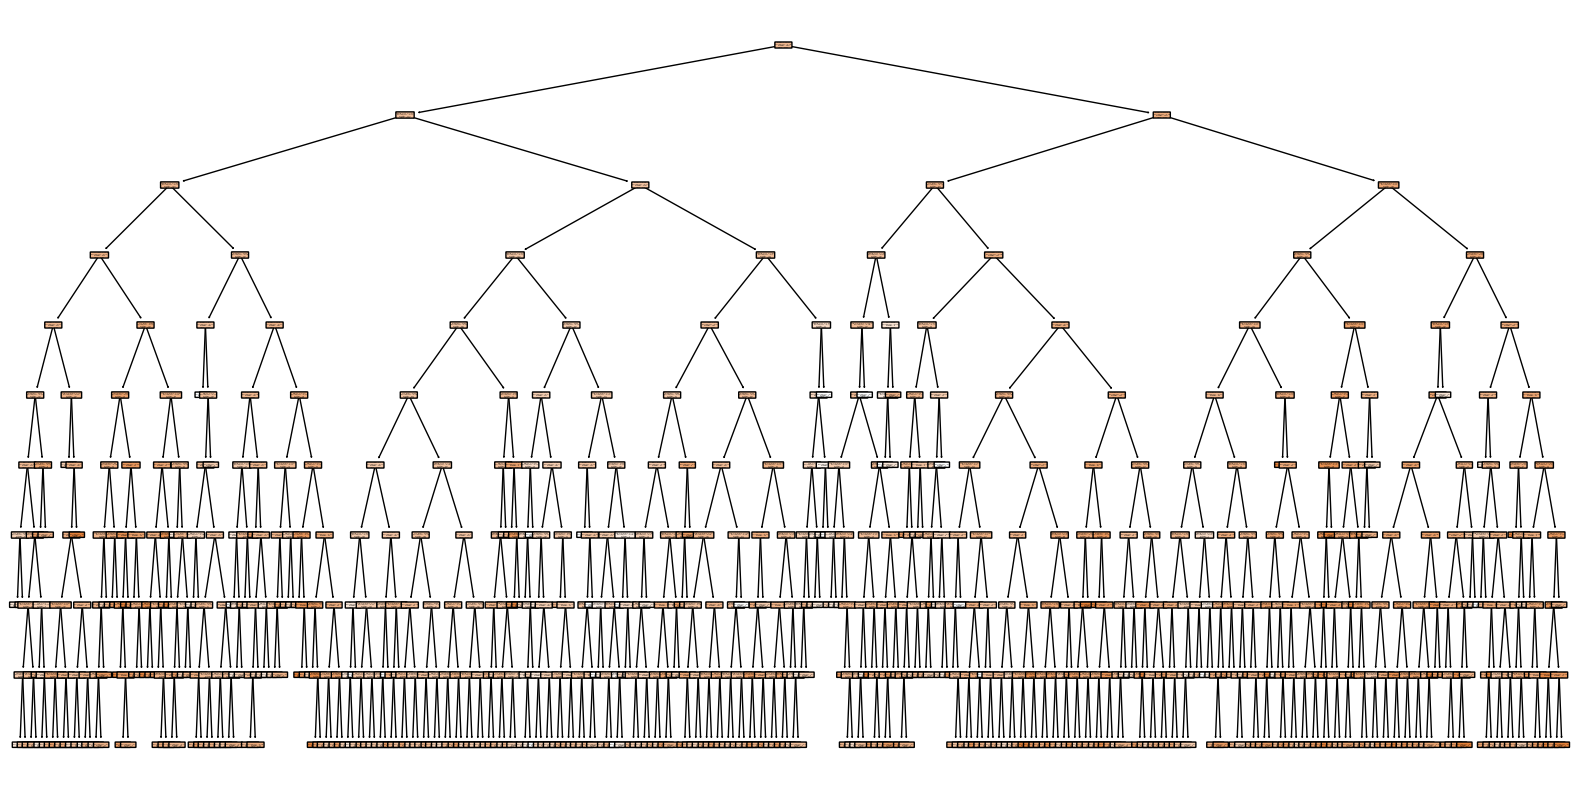

In [ ]:
dt = DecisionTreeRegressor(max_depth=10, random_state=42) #поменяем глубину и random state
dt.fit(X_train, y_train)
plt.figure(figsize=(20, 10))  # установка размера фигуры 20x10
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [ ]:
mean_squared_error(y_test, dt.predict(X_test))* 100

57.04742167401516

Суть в том, что если увеличивать глубину модели, то и увеличивается MSE, картинка страшная, так как деревья склонны переобучаться, то возможно, это и произошло.

# **Логистическая регрессия**

In [ ]:
df.head().copy()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1            7.0              0.27         0.36            20.7   
1     1            6.3              0.30         0.34             1.6   
2     1            8.1              0.28         0.40             6.9   
3     1            7.2              0.23         0.32             8.5   
4     1            7.2              0.23         0.32             8.5   

   chlorides  total sulfur dioxide  density    pH  sulphates  alcohol  quality  
0      0.045                 170.0   1.0010  3.00       0.45      8.8        6  
1      0.049                 132.0   0.9940  3.30       0.49      9.5        6  
2      0.050                  97.0   0.9951  3.26       0.44     10.1        6  
3      0.058                 186.0   0.9956  3.19       0.40      9.9        6  
4      0.058                 186.0   0.9956  3.19       0.40      9.9        6

In [ ]:
X = df.drop('quality', axis=1)
y = df['quality']
# Разделим данные на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y)

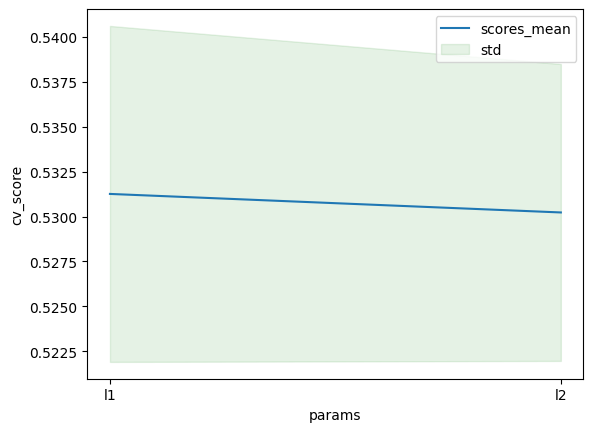

Best params: {'penalty': 'l1'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        23
           4       1.00      0.01      0.01       157
           5       0.58      0.61      0.60      1605
           6       0.51      0.74      0.60      2119
           7       0.53      0.07      0.12       798
           8       0.00      0.00      0.00       145

    accuracy                           0.53      4847
   macro avg       0.44      0.24      0.22      4847
weighted avg       0.53      0.53      0.48      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        57
           5       0.61      0.62      0.61       523
           6       0.52      0.77      0.62       701
           7       0.53      0.07      0.12       276
           8       0.00      0.00      0.00        52

    accuracy                           0.55   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
model = LogisticRegression(solver='liblinear')
hyperparams = ['l1', 'l2']
param_grid = {'penalty': hyperparams}
model_train(model, param_grid, hyperparams)

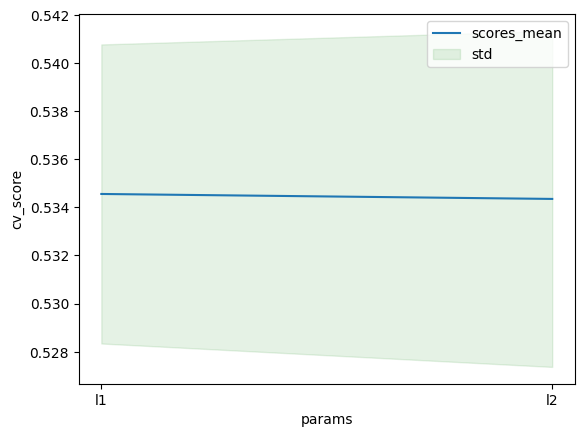

Best params: {'logisticregression__penalty': 'l1'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        23
           4       0.80      0.03      0.05       157
           5       0.59      0.61      0.60      1605
           6       0.51      0.73      0.60      2119
           7       0.55      0.12      0.20       798
           8       0.00      0.00      0.00       145

    accuracy                           0.54      4847
   macro avg       0.41      0.25      0.24      4847
weighted avg       0.54      0.54      0.50      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        57
           5       0.61      0.63      0.62       523
           6       0.52      0.77      0.62       701
           7       0.52      0.09      0.16       276
           8       0.00      0.00      0.00        52

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
scale = StandardScaler()
lr = LogisticRegression(solver='liblinear')
model = make_pipeline(scale, lr)
hyperparams = ['l1', 'l2']
param_grid = {'logisticregression__penalty': hyperparams}
model_train(model, param_grid, hyperparams)